In [161]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from preprocessing.missing_value_imputation import missing_value_imputation
from preprocessing.train_autoencoder import train_autoencoder
from preprocessing.normalization import normalize_data
from models.autoencoder import Autoencoder
from models.cnn import CNN, CNNForBC
from models.multilayerperceptron import MultilayerPerceptron, MultilayerPerceptronForPCA, MultilayerPerceptronForBC
from helper.evals import precision, recall, f1_score, test_model, train_model, precision_recall_multiclass, prepare_train, train_model_k_fold, prepare_train_k_fold, prepare_train_k_fold_with_normalization_and_imputation
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from helper.plot_graphs import plot_confusion_matrix, plot_train_and_test_set
from torchsummary import summary
from models.logistic_regression import LogisticRegression, LogisticRegressionForBC
from Sklearn_PyTorch.random_forest import TorchRandomForestClassifier, TorchDecisionTreeRegressor
%reload_ext autoreload
%autoreload 2

# Utku Sabri Kaya 504231535
# Haniyeh Dousti 504211557


In [ ]:
# prad_2019a_merged_data # PRAD
# prad_2019b_merged_data # PRAD 
# prad_2014_merged_data # PRAD
# coad_merged_data # COAD
# pdac_merged_data # PDAC
# rc20_merged_data # ccRCC4
# rc18mr_merged_data # ccRCC3
# brca_terunuma_merged_data # BRCA1

In [2]:
rc18mr_merged_data = pd.read_csv('edited dataset/merged_data/rc18mr_merged_data.csv')
pdac_merged_data = pd.read_csv('edited dataset/merged_data/pdac_merged_data.csv')
brca_terunuma_merged_data = pd.read_csv('edited dataset/merged_data/brca_terunuma_merged_data.csv')
coad_merged_data = pd.read_csv('edited dataset/merged_data/coad_merged_data.csv')
prad_2019a_merged_data = pd.read_csv('edited dataset/merged_data/prad_2019a_merged_data.csv')
prad_2019b_merged_data = pd.read_csv('edited dataset/merged_data/prad_2019b_merged_data.csv')
prad_2014_merged_data = pd.read_csv('edited dataset/merged_data/prad_2014_merged_data.csv')
rc20_merged_data = pd.read_csv('edited dataset/merged_data/rc20_merged_data.csv')

In [3]:
rc18mr_merged_data.insert(0, 'Labels', rc18mr_merged_data['TN'].apply(lambda x: 1 if x == 'Tumor' else 0))
pdac_merged_data.insert(0, 'Labels', pdac_merged_data['TN'].apply(lambda x: 1 if x == 'Tumor' else 0))
brca_terunuma_merged_data.insert(0, 'Labels', brca_terunuma_merged_data['TN'].apply(lambda x: 1 if x == 'Tumor' else 0))
coad_merged_data.insert(0, 'Labels', coad_merged_data['TN'].apply(lambda x: 1 if x == 'Tumor' else 0))
prad_2019a_merged_data.insert(0, 'Labels', prad_2019a_merged_data['TN'].apply(lambda x: 1 if x == 'Tumor' else 0))
prad_2019b_merged_data.insert(0, 'Labels', prad_2019b_merged_data['TN'].apply(lambda x: 1 if x == 'Tumor' else 0))
prad_2014_merged_data.insert(0, 'Labels', prad_2014_merged_data['TN'].apply(lambda x: 1 if x == 'Tumor' else 0))
rc20_merged_data.insert(0, 'Labels', rc20_merged_data['TN'].apply(lambda x: 1 if x == 'Tumor' else 0))


In [4]:
rc18mr_data = rc18mr_merged_data.iloc[:,5:]
rc18mr_labels = rc18mr_merged_data.iloc[:,:1]

pdac_data = pdac_merged_data.iloc[:,5:]
pdac_labels = pdac_merged_data.iloc[:,:1]

brca_terunuma_data = brca_terunuma_merged_data.iloc[:,5:]
brca_terunuma_labels = brca_terunuma_merged_data.iloc[:,:1]

coad_data = coad_merged_data.iloc[:,5:]
coad_labels = coad_merged_data.iloc[:,:1]

prad_2019a_data = prad_2019a_merged_data.iloc[:,5:]
prad_2019a_labels = prad_2019a_merged_data.iloc[:,:1]

prad_2019b_data = prad_2019b_merged_data.iloc[:,5:]
prad_2019b_labels = prad_2019b_merged_data.iloc[:,:1]

prad_2014_data = prad_2014_merged_data.iloc[:,5:]
prad_2014_labels = prad_2014_merged_data.iloc[:,:1]

rc20_data = rc20_merged_data.iloc[:,5:]
rc20_labels = rc20_merged_data.iloc[:,:1]

In [29]:
def feature_extraction(data):
    X_train, X_test = train_test_split(data.values, test_size=0.2, random_state=42)

    data_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    data_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    data_tensor = torch.tensor(data.values, dtype=torch.float32)

    input_dim = len(data.values[0])
    encoding_dim = 2000 # len(data.values[0]) // 5
    autoencoder = Autoencoder(input_dim, encoding_dim)


    autoencoder = train_autoencoder(
                    model=Autoencoder(input_dim, encoding_dim), 
                    train_data=data_train_tensor,
                    test_data=data_test_tensor, 
                    optimizer=optim.Adam(autoencoder.parameters(), lr=0.001), 
                    criterion=nn.MSELoss(), 
                    n_epoch=10)


    data_dim_red = autoencoder.encoder(data_tensor)
    return data_dim_red

def remove_zero_columns(data):
    return data.loc[:, (data != 0.0).any(axis=0)]


In [10]:
rc18mr_data_dim_red = remove_zero_columns((pd.DataFrame(feature_extraction(rc18mr_data).detach().numpy())))


Test Loss: nan
Epoch [10/10], Loss: nan


In [34]:
prad_2019a_data.shape


(75, 28303)

In [205]:
datas = [prad_2019a_data, coad_data, pdac_data, rc18mr_data, rc20_data, brca_terunuma_data]
labels = [prad_2019a_labels, coad_labels, pdac_labels, rc18mr_labels, rc20_labels, brca_terunuma_labels]
names = ['PRAD', 'COAD', 'PDAC', 'ccRCC3', 'ccRCC4', 'BRCA']
train_losses_cnn = {}
train_accs_cnn = {}
train_points_cnn = {}
test_losses_cnn = {}
test_accs_cnn = {}
test_points_cnn = {}
train_precs_cnn = {}
train_recalls_cnn = {}
train_f1s_cnn = {}
test_precs_cnn = {}
test_recalls_cnn = {}
test_f1s_cnn = {}
models_cnn = {}

train_losses_mlp = {}
train_accs_mlp = {}
train_points_mlp = {}
test_losses_mlp = {}
test_accs_mlp = {}
test_points_mlp = {}
train_precs_mlp = {}
train_recalls_mlp = {}
train_f1s_mlp = {}
test_precs_mlp = {}
test_recalls_mlp = {}
test_f1s_mlp = {}
models_mlp = {}

train_losses_logistic_regression = {}
train_accs_logistic_regression = {}
train_points_logistic_regression = {}
test_losses_logistic_regression = {}
test_accs_logistic_regression = {}
test_points_logistic_regression = {}
train_precs_logistic_regression = {}
train_recalls_logistic_regression = {}
train_f1s_logistic_regression = {}
test_precs_logistic_regression = {}
test_recalls_logistic_regression = {}
test_f1s_logistic_regression = {}
models_logistic_regression = {}

In [207]:
for i in range(len(datas)):
    model_autoencoder_cnn = CNN(input_size=500, output_size=2)
    model_autoencoder_cnn, train_accs_autoencoder_cnn, train_losses_autoencoder_cnn, train_points_autoencoder_cnn, train_prec_autoencoder_cnn, train_recall_autoencoder_cnn, train_f1_autoencoder_cnn, test_accs_autoencoder_cnn, test_losses_autoencoder_cnn, test_points_autoencoder_cnn, test_prec_autoencoder_cnn, test_recall_autoencoder_cnn, test_f1_autoencoder_cnn = prepare_train_k_fold_with_normalization_and_imputation(model_autoencoder_cnn, datas[i].values, labels[i]['Labels'].values, reshape_size=datas[i].shape[1], n_epochs=10)
    train_accs_cnn[names[i]] = train_accs_autoencoder_cnn
    train_losses_cnn[names[i]] = train_losses_autoencoder_cnn
    train_points_cnn[names[i]] = train_points_autoencoder_cnn
    train_precs_cnn[names[i]] = train_prec_autoencoder_cnn
    train_recalls_cnn[names[i]] = train_recall_autoencoder_cnn
    train_f1s_cnn[names[i]] = train_f1_autoencoder_cnn
    test_accs_cnn[names[i]] = test_accs_autoencoder_cnn
    test_losses_cnn[names[i]] = test_losses_autoencoder_cnn
    test_points_cnn[names[i]] = test_points_autoencoder_cnn
    test_precs_cnn[names[i]] = test_prec_autoencoder_cnn
    test_recalls_cnn[names[i]] = test_recall_autoencoder_cnn
    test_f1s_cnn[names[i]] = test_f1_autoencoder_cnn
    models_cnn[names[i]] = model_autoencoder_cnn

Test Loss: 0.0484
Epoch [10/10], Loss: 0.0518
(75, 2000)
TRAIN:	Epoch:   0, Loss: 0.70635, Accuracy: 31.34328
TEST:	Epoch:   0, Loss: 0.70635, Accuracy: 75.00000


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1574
Epoch [10/10], Loss: 0.1588
(75, 2000)
TRAIN:	Epoch:  10, Loss: 0.62183, Accuracy: 68.65672
TEST:	Epoch:  10, Loss: 0.62183, Accuracy: 75.00000
Test Loss: 0.1592
Epoch [10/10], Loss: 0.1601
(75, 2000)
TRAIN:	Epoch:  20, Loss: 0.60945, Accuracy: 70.14925
TEST:	Epoch:  20, Loss: 0.60945, Accuracy: 62.50000
Test Loss: 0.1613
Epoch [10/10], Loss: 0.1623
(75, 2000)
TRAIN:	Epoch:  30, Loss: 0.61022, Accuracy: 70.14925
TEST:	Epoch:  30, Loss: 0.61022, Accuracy: 62.50000
Test Loss: 0.1659
Epoch [10/10], Loss: 0.1662
(75, 2000)
TRAIN:	Epoch:  40, Loss: 0.61262, Accuracy: 70.14925
TEST:	Epoch:  40, Loss: 0.61262, Accuracy: 62.50000
TEST:	Epoch:  49, Loss: 0.56313, Accuracy: 62.50000
Test Loss: 0.1642
Epoch [10/10], Loss: 0.1643
(75, 2000)
TRAIN:	Epoch:  50, Loss: 0.63482, Accuracy: 69.11765
TEST:	Epoch:  50, Loss: 0.63482, Accuracy: 71.42857
Test Loss: 0.1626
Epoch [10/10], Loss: 0.1630
(75, 2000)
TRAIN:	Epoch:  60, Loss: 0.63729, Accuracy: 69.11765
TEST:	Epoch:  60, Loss: 0.63

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metabol

Test Loss: 0.1600
Epoch [10/10], Loss: 0.1584
(76, 2000)
TRAIN:	Epoch:  10, Loss: 0.69356, Accuracy: 51.47059
TEST:	Epoch:  10, Loss: 0.69356, Accuracy: 50.00000


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metabol

Test Loss: 0.1632
Epoch [10/10], Loss: 0.1620
(76, 2000)
TRAIN:	Epoch:  20, Loss: 0.69310, Accuracy: 50.00000
TEST:	Epoch:  20, Loss: 0.69310, Accuracy: 50.00000


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metabol

Test Loss: 0.1630
Epoch [10/10], Loss: 0.1633
(76, 2000)


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch:  30, Loss: 0.69846, Accuracy: 51.47059
TEST:	Epoch:  30, Loss: 0.69846, Accuracy: 50.00000
Test Loss: 0.1655
Epoch [10/10], Loss: 0.1654
(76, 2000)
TRAIN:	Epoch:  40, Loss: 0.71791, Accuracy: 48.52941
TEST:	Epoch:  40, Loss: 0.71791, Accuracy: 50.00000


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TEST:	Epoch:  49, Loss: 0.56048, Accuracy: 100.00000
Test Loss: 0.1674
Epoch [10/10], Loss: 0.1672
(76, 2000)
TRAIN:	Epoch:  50, Loss: 0.71949, Accuracy: 48.52941
TEST:	Epoch:  50, Loss: 0.71949, Accuracy: 50.00000


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1660
Epoch [10/10], Loss: 0.1663
(76, 2000)
TRAIN:	Epoch:  60, Loss: 0.72614, Accuracy: 52.17391
TEST:	Epoch:  60, Loss: 0.72614, Accuracy: 57.14286
Test Loss: 0.1687
Epoch [10/10], Loss: 0.1681
(76, 2000)
TRAIN:	Epoch:  70, Loss: 0.63829, Accuracy: 69.56522
TEST:	Epoch:  70, Loss: 0.63829, Accuracy: 57.14286
Test Loss: 0.1646
Epoch [10/10], Loss: 0.1638
(76, 2000)
TRAIN:	Epoch:  80, Loss: 0.88361, Accuracy: 50.72464
TEST:	Epoch:  80, Loss: 0.88361, Accuracy: 57.14286


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1674
Epoch [10/10], Loss: 0.1665
(76, 2000)
TRAIN:	Epoch:  90, Loss: 0.66634, Accuracy: 63.76812
TEST:	Epoch:  90, Loss: 0.66634, Accuracy: 28.57143
Test Loss: 0.0728
Epoch [10/10], Loss: 0.0665
(39, 2000)


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch:   0, Loss: 0.70581, Accuracy: 28.57143
TEST:	Epoch:   0, Loss: 0.70581, Accuracy: 50.00000
Test Loss: 0.1620
Epoch [10/10], Loss: 0.1604
(39, 2000)
TRAIN:	Epoch:  10, Loss: 0.59897, Accuracy: 71.42857
TEST:	Epoch:  10, Loss: 0.59897, Accuracy: 50.00000
Test Loss: 0.1669
Epoch [10/10], Loss: 0.1652
(39, 2000)
TRAIN:	Epoch:  20, Loss: 0.62722, Accuracy: 68.57143
TEST:	Epoch:  20, Loss: 0.62722, Accuracy: 75.00000
Test Loss: 0.1662
Epoch [10/10], Loss: 0.1645
(39, 2000)
TRAIN:	Epoch:  30, Loss: 0.63189, Accuracy: 68.57143
TEST:	Epoch:  30, Loss: 0.63189, Accuracy: 75.00000
Test Loss: 0.1677
Epoch [10/10], Loss: 0.1675
(39, 2000)
TRAIN:	Epoch:  40, Loss: 0.68228, Accuracy: 68.57143
TEST:	Epoch:  40, Loss: 0.68228, Accuracy: 75.00000
TEST:	Epoch:  49, Loss: 0.45924, Accuracy: 75.00000
Test Loss: 0.1688
Epoch [10/10], Loss: 0.1678
(39, 2000)
TRAIN:	Epoch:  50, Loss: 0.65728, Accuracy: 68.57143
TEST:	Epoch:  50, Loss: 0.65728, Accuracy: 75.00000
Test Loss: 0.1693
Epoch [10/10], 

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1054
Epoch [10/10], Loss: 0.1052
(114, 2000)


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch:   0, Loss: 0.69506, Accuracy: 41.17647
TEST:	Epoch:   0, Loss: 0.69506, Accuracy: 58.33333
Test Loss: 0.1579
Epoch [10/10], Loss: 0.1581
(114, 2000)
TRAIN:	Epoch:  10, Loss: 0.68128, Accuracy: 58.82353
TEST:	Epoch:  10, Loss: 0.68128, Accuracy: 58.33333
Test Loss: 0.1632
Epoch [10/10], Loss: 0.1628
(114, 2000)
TRAIN:	Epoch:  20, Loss: 0.66963, Accuracy: 58.82353
TEST:	Epoch:  20, Loss: 0.66963, Accuracy: 75.00000
Test Loss: 0.1651
Epoch [10/10], Loss: 0.1648
(114, 2000)
TRAIN:	Epoch:  30, Loss: 0.81596, Accuracy: 58.82353
TEST:	Epoch:  30, Loss: 0.81596, Accuracy: 41.66667
Test Loss: 0.1650
Epoch [10/10], Loss: 0.1651
(114, 2000)
TRAIN:	Epoch:  40, Loss: 0.65993, Accuracy: 61.16505
TEST:	Epoch:  40, Loss: 0.65993, Accuracy: 54.54545
TEST:	Epoch:  49, Loss: 0.54407, Accuracy: 63.63636
Test Loss: 0.1687
Epoch [10/10], Loss: 0.1682
(114, 2000)
TRAIN:	Epoch:  50, Loss: 0.67081, Accuracy: 59.22330
TEST:	Epoch:  50, Loss: 0.67081, Accuracy: 54.54545
Test Loss: 0.1675
Epoch [10/

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1650
Epoch [10/10], Loss: 0.1624
(76, 2000)
TRAIN:	Epoch:  10, Loss: 0.64009, Accuracy: 67.64706
TEST:	Epoch:  10, Loss: 0.64009, Accuracy: 75.00000
Test Loss: 0.1659
Epoch [10/10], Loss: 0.1649
(76, 2000)
TRAIN:	Epoch:  20, Loss: 0.61849, Accuracy: 69.11765
TEST:	Epoch:  20, Loss: 0.61849, Accuracy: 62.50000
Test Loss: 0.1674
Epoch [10/10], Loss: 0.1666
(76, 2000)
TRAIN:	Epoch:  30, Loss: 0.61014, Accuracy: 69.11765
TEST:	Epoch:  30, Loss: 0.61014, Accuracy: 62.50000
Test Loss: 0.1655
Epoch [10/10], Loss: 0.1656
(76, 2000)
TRAIN:	Epoch:  40, Loss: 0.67501, Accuracy: 69.11765
TEST:	Epoch:  40, Loss: 0.67501, Accuracy: 62.50000
TEST:	Epoch:  49, Loss: 0.36800, Accuracy: 100.00000
Test Loss: 0.1651
Epoch [10/10], Loss: 0.1647
(76, 2000)
TRAIN:	Epoch:  50, Loss: 0.61362, Accuracy: 69.11765
TEST:	Epoch:  50, Loss: 0.61362, Accuracy: 75.00000
Test Loss: 0.1659
Epoch [10/10], Loss: 0.1651
(76, 2000)
TRAIN:	Epoch:  60, Loss: 0.72945, Accuracy: 68.11594
TEST:	Epoch:  60, Loss: 0.7

In [208]:
for i in range(len(datas)):
    model_autoencoder_logistic_regression = LogisticRegressionForBC(input_size=2000, output_size=2)
    model_autoencoder_logistic_regression, train_accs_autoencoder_logistic_regression, train_losses_autoencoder_logistic_regression, train_points_autoencoder_logistic_regression, train_prec_autoencoder_logistic_regression, train_recall_autoencoder_logistic_regression, train_f1_autoencoder_logistic_regression, test_accs_autoencoder_logistic_regression, test_losses_autoencoder_logistic_regression, test_points_autoencoder_logistic_regression, test_prec_autoencoder_logistic_regression, test_recall_autoencoder_logistic_regression, test_f1_autoencoder_logistic_regression = prepare_train_k_fold_with_normalization_and_imputation(model_autoencoder_logistic_regression, datas[i].values, labels[i]['Labels'].values, reshape_size=datas[i].shape[1], n_epochs=100)
    train_accs_logistic_regression[names[i]] = train_accs_autoencoder_logistic_regression
    train_losses_logistic_regression[names[i]] = train_losses_autoencoder_logistic_regression
    train_points_logistic_regression[names[i]] = train_points_autoencoder_logistic_regression
    train_precs_logistic_regression[names[i]] = train_prec_autoencoder_logistic_regression
    train_recalls_logistic_regression[names[i]] = train_recall_autoencoder_logistic_regression
    train_f1s_logistic_regression[names[i]] = train_f1_autoencoder_logistic_regression
    test_accs_logistic_regression[names[i]] = test_accs_autoencoder_logistic_regression
    test_losses_logistic_regression[names[i]] = test_losses_autoencoder_logistic_regression
    test_points_logistic_regression[names[i]] = test_points_autoencoder_logistic_regression
    test_precs_logistic_regression[names[i]] = test_prec_autoencoder_logistic_regression
    test_recalls_logistic_regression[names[i]] = test_recall_autoencoder_logistic_regression
    test_f1s_logistic_regression[names[i]] = test_f1_autoencoder_logistic_regression

    models_logistic_regression[names[i]] = model_autoencoder_logistic_regression

Test Loss: 0.0484
Epoch [10/10], Loss: 0.0519
(75, 2000)
TRAIN:	Epoch:   0, Loss: 0.70828, Accuracy: 31.34328
TEST:	Epoch:   0, Loss: 0.70828, Accuracy: 75.00000
TRAIN:	Epoch:  10, Loss: 0.58648, Accuracy: 68.65672
TEST:	Epoch:  10, Loss: 0.58648, Accuracy: 75.00000


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch:  20, Loss: 0.44637, Accuracy: 73.13433
TEST:	Epoch:  20, Loss: 0.44637, Accuracy: 75.00000
TRAIN:	Epoch:  30, Loss: 0.21368, Accuracy: 95.52239
TEST:	Epoch:  30, Loss: 0.21368, Accuracy: 87.50000
TRAIN:	Epoch:  40, Loss: 0.03030, Accuracy: 100.00000
TEST:	Epoch:  40, Loss: 0.03030, Accuracy: 87.50000
TRAIN:	Epoch:  50, Loss: 0.00159, Accuracy: 100.00000
TEST:	Epoch:  50, Loss: 0.00159, Accuracy: 87.50000
TRAIN:	Epoch:  60, Loss: 0.00032, Accuracy: 100.00000
TEST:	Epoch:  60, Loss: 0.00032, Accuracy: 87.50000
TRAIN:	Epoch:  70, Loss: 0.00014, Accuracy: 100.00000
TEST:	Epoch:  70, Loss: 0.00014, Accuracy: 87.50000
TRAIN:	Epoch:  80, Loss: 0.00010, Accuracy: 100.00000
TEST:	Epoch:  80, Loss: 0.00010, Accuracy: 87.50000
TRAIN:	Epoch:  90, Loss: 0.00008, Accuracy: 100.00000
TEST:	Epoch:  90, Loss: 0.00008, Accuracy: 87.50000
Test Loss: 0.1547
Epoch [10/10], Loss: 0.1559
(75, 2000)
TRAIN:	Epoch: 100, Loss: 3.54082, Accuracy: 68.65672
TEST:	Epoch: 100, Loss: 3.54082, Accuracy: 7

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch: 120, Loss: 0.09888, Accuracy: 98.52941
TEST:	Epoch: 120, Loss: 0.09888, Accuracy: 87.50000
TRAIN:	Epoch: 130, Loss: 0.06384, Accuracy: 98.52941
TEST:	Epoch: 130, Loss: 0.06384, Accuracy: 87.50000
TRAIN:	Epoch: 140, Loss: 0.04374, Accuracy: 98.52941
TEST:	Epoch: 140, Loss: 0.04374, Accuracy: 87.50000
TRAIN:	Epoch: 150, Loss: 0.02456, Accuracy: 98.52941
TEST:	Epoch: 150, Loss: 0.02456, Accuracy: 87.50000
TRAIN:	Epoch: 160, Loss: 0.00856, Accuracy: 100.00000
TEST:	Epoch: 160, Loss: 0.00856, Accuracy: 87.50000
TRAIN:	Epoch: 170, Loss: 0.00169, Accuracy: 100.00000
TEST:	Epoch: 170, Loss: 0.00169, Accuracy: 87.50000
TRAIN:	Epoch: 180, Loss: 0.00058, Accuracy: 100.00000
TEST:	Epoch: 180, Loss: 0.00058, Accuracy: 87.50000
TRAIN:	Epoch: 190, Loss: 0.00027, Accuracy: 100.00000
TEST:	Epoch: 190, Loss: 0.00027, Accuracy: 87.50000
Test Loss: 0.1622
Epoch [10/10], Loss: 0.1609
(76, 2000)
TRAIN:	Epoch: 200, Loss: 2.05450, Accuracy: 41.17647
TEST:	Epoch: 200, Loss: 2.05450, Accuracy: 37.

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch: 230, Loss: 0.00706, Accuracy: 100.00000
TEST:	Epoch: 230, Loss: 0.00706, Accuracy: 100.00000
TRAIN:	Epoch: 240, Loss: 0.00278, Accuracy: 100.00000
TEST:	Epoch: 240, Loss: 0.00278, Accuracy: 100.00000
TRAIN:	Epoch: 250, Loss: 0.00214, Accuracy: 100.00000
TEST:	Epoch: 250, Loss: 0.00214, Accuracy: 100.00000
TRAIN:	Epoch: 260, Loss: 0.00189, Accuracy: 100.00000
TEST:	Epoch: 260, Loss: 0.00189, Accuracy: 100.00000
TRAIN:	Epoch: 270, Loss: 0.00161, Accuracy: 100.00000
TEST:	Epoch: 270, Loss: 0.00161, Accuracy: 100.00000
TRAIN:	Epoch: 280, Loss: 0.00143, Accuracy: 100.00000
TEST:	Epoch: 280, Loss: 0.00143, Accuracy: 100.00000
TRAIN:	Epoch: 290, Loss: 0.00130, Accuracy: 100.00000
TEST:	Epoch: 290, Loss: 0.00130, Accuracy: 100.00000
Test Loss: 0.1688
Epoch [10/10], Loss: 0.1667
(39, 2000)
TRAIN:	Epoch: 300, Loss: 1.82993, Accuracy: 68.57143
TEST:	Epoch: 300, Loss: 1.82993, Accuracy: 25.00000
TRAIN:	Epoch: 310, Loss: 0.25403, Accuracy: 91.42857
TEST:	Epoch: 310, Loss: 0.25403, Acc

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch: 330, Loss: 0.01276, Accuracy: 100.00000
TEST:	Epoch: 330, Loss: 0.01276, Accuracy: 100.00000
TRAIN:	Epoch: 340, Loss: 0.00588, Accuracy: 100.00000
TEST:	Epoch: 340, Loss: 0.00588, Accuracy: 100.00000
TRAIN:	Epoch: 350, Loss: 0.00419, Accuracy: 100.00000
TEST:	Epoch: 350, Loss: 0.00419, Accuracy: 100.00000
TRAIN:	Epoch: 360, Loss: 0.00307, Accuracy: 100.00000
TEST:	Epoch: 360, Loss: 0.00307, Accuracy: 100.00000
TRAIN:	Epoch: 370, Loss: 0.00255, Accuracy: 100.00000
TEST:	Epoch: 370, Loss: 0.00255, Accuracy: 100.00000
TRAIN:	Epoch: 380, Loss: 0.00217, Accuracy: 100.00000
TEST:	Epoch: 380, Loss: 0.00217, Accuracy: 100.00000
TRAIN:	Epoch: 390, Loss: 0.00187, Accuracy: 100.00000
TEST:	Epoch: 390, Loss: 0.00187, Accuracy: 100.00000
Test Loss: 0.1682
Epoch [10/10], Loss: 0.1668
(39, 2000)
TRAIN:	Epoch: 400, Loss: 1.03178, Accuracy: 74.28571
TEST:	Epoch: 400, Loss: 1.03178, Accuracy: 75.00000
TRAIN:	Epoch: 410, Loss: 0.19510, Accuracy: 94.28571
TEST:	Epoch: 410, Loss: 0.19510, Acc

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch: 220, Loss: 0.11218, Accuracy: 95.09804
TEST:	Epoch: 220, Loss: 0.11218, Accuracy: 83.33333
TRAIN:	Epoch: 230, Loss: 0.05003, Accuracy: 99.01961
TEST:	Epoch: 230, Loss: 0.05003, Accuracy: 100.00000
TRAIN:	Epoch: 240, Loss: 0.03102, Accuracy: 100.00000
TEST:	Epoch: 240, Loss: 0.03102, Accuracy: 100.00000
TRAIN:	Epoch: 250, Loss: 0.01544, Accuracy: 100.00000
TEST:	Epoch: 250, Loss: 0.01544, Accuracy: 100.00000
TRAIN:	Epoch: 260, Loss: 0.00749, Accuracy: 100.00000
TEST:	Epoch: 260, Loss: 0.00749, Accuracy: 100.00000
TRAIN:	Epoch: 270, Loss: 0.00414, Accuracy: 100.00000
TEST:	Epoch: 270, Loss: 0.00414, Accuracy: 100.00000
TRAIN:	Epoch: 280, Loss: 0.00241, Accuracy: 100.00000
TEST:	Epoch: 280, Loss: 0.00241, Accuracy: 100.00000
TRAIN:	Epoch: 290, Loss: 0.00151, Accuracy: 100.00000
TEST:	Epoch: 290, Loss: 0.00151, Accuracy: 100.00000
Test Loss: 0.1648
Epoch [10/10], Loss: 0.1647
(114, 2000)
TRAIN:	Epoch: 300, Loss: 1.57261, Accuracy: 34.31373
TEST:	Epoch: 300, Loss: 1.57261, Acc

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch:  20, Loss: 0.14608, Accuracy: 100.00000
TEST:	Epoch:  20, Loss: 0.14608, Accuracy: 100.00000
TRAIN:	Epoch:  30, Loss: 0.02430, Accuracy: 100.00000
TEST:	Epoch:  30, Loss: 0.02430, Accuracy: 100.00000
TRAIN:	Epoch:  40, Loss: 0.00041, Accuracy: 100.00000
TEST:	Epoch:  40, Loss: 0.00041, Accuracy: 100.00000
TRAIN:	Epoch:  50, Loss: 0.00003, Accuracy: 100.00000
TEST:	Epoch:  50, Loss: 0.00003, Accuracy: 100.00000
TRAIN:	Epoch:  60, Loss: 0.00001, Accuracy: 100.00000
TEST:	Epoch:  60, Loss: 0.00001, Accuracy: 100.00000
TRAIN:	Epoch:  70, Loss: 0.00001, Accuracy: 100.00000
TEST:	Epoch:  70, Loss: 0.00001, Accuracy: 100.00000
TRAIN:	Epoch:  80, Loss: 0.00001, Accuracy: 100.00000
TEST:	Epoch:  80, Loss: 0.00001, Accuracy: 100.00000
TRAIN:	Epoch:  90, Loss: 0.00001, Accuracy: 100.00000
TEST:	Epoch:  90, Loss: 0.00001, Accuracy: 100.00000
Test Loss: 0.1657
Epoch [10/10], Loss: 0.1654
(76, 2000)
TRAIN:	Epoch: 100, Loss: 10.17305, Accuracy: 67.64706
TEST:	Epoch: 100, Loss: 10.17305,

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metabol

TRAIN:	Epoch: 120, Loss: 0.16379, Accuracy: 95.58824
TEST:	Epoch: 120, Loss: 0.16379, Accuracy: 100.00000
TRAIN:	Epoch: 130, Loss: 0.11659, Accuracy: 100.00000
TEST:	Epoch: 130, Loss: 0.11659, Accuracy: 100.00000
TRAIN:	Epoch: 140, Loss: 0.05991, Accuracy: 100.00000
TEST:	Epoch: 140, Loss: 0.05991, Accuracy: 100.00000
TRAIN:	Epoch: 150, Loss: 0.02717, Accuracy: 100.00000
TEST:	Epoch: 150, Loss: 0.02717, Accuracy: 100.00000
TRAIN:	Epoch: 160, Loss: 0.01118, Accuracy: 100.00000
TEST:	Epoch: 160, Loss: 0.01118, Accuracy: 100.00000
TRAIN:	Epoch: 170, Loss: 0.00499, Accuracy: 100.00000
TEST:	Epoch: 170, Loss: 0.00499, Accuracy: 100.00000
TRAIN:	Epoch: 180, Loss: 0.00268, Accuracy: 100.00000
TEST:	Epoch: 180, Loss: 0.00268, Accuracy: 100.00000
TRAIN:	Epoch: 190, Loss: 0.00169, Accuracy: 100.00000
TEST:	Epoch: 190, Loss: 0.00169, Accuracy: 100.00000
Test Loss: 0.1654
Epoch [10/10], Loss: 0.1644
(76, 2000)
TRAIN:	Epoch: 200, Loss: 4.78879, Accuracy: 69.11765
TEST:	Epoch: 200, Loss: 4.78879, Ac

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch: 620, Loss: 0.18461, Accuracy: 100.00000
TEST:	Epoch: 620, Loss: 0.18461, Accuracy: 100.00000
TRAIN:	Epoch: 630, Loss: 0.08699, Accuracy: 100.00000
TEST:	Epoch: 630, Loss: 0.08699, Accuracy: 100.00000
TRAIN:	Epoch: 640, Loss: 0.04858, Accuracy: 100.00000
TEST:	Epoch: 640, Loss: 0.04858, Accuracy: 100.00000
TRAIN:	Epoch: 650, Loss: 0.02649, Accuracy: 100.00000
TEST:	Epoch: 650, Loss: 0.02649, Accuracy: 100.00000
TRAIN:	Epoch: 660, Loss: 0.01638, Accuracy: 100.00000
TEST:	Epoch: 660, Loss: 0.01638, Accuracy: 100.00000
TRAIN:	Epoch: 670, Loss: 0.01173, Accuracy: 100.00000
TEST:	Epoch: 670, Loss: 0.01173, Accuracy: 100.00000
TRAIN:	Epoch: 680, Loss: 0.00881, Accuracy: 100.00000
TEST:	Epoch: 680, Loss: 0.00881, Accuracy: 100.00000
TRAIN:	Epoch: 690, Loss: 0.00699, Accuracy: 100.00000
TEST:	Epoch: 690, Loss: 0.00699, Accuracy: 100.00000
Test Loss: 0.1685
Epoch [10/10], Loss: 0.1684
(76, 2000)
TRAIN:	Epoch: 700, Loss: 1.63038, Accuracy: 68.11594
TEST:	Epoch: 700, Loss: 1.63038, A

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch:  20, Loss: 0.18250, Accuracy: 93.81443
TEST:	Epoch:  20, Loss: 0.18250, Accuracy: 90.90909
TRAIN:	Epoch:  30, Loss: 0.04747, Accuracy: 98.96907
TEST:	Epoch:  30, Loss: 0.04747, Accuracy: 90.90909
TRAIN:	Epoch:  40, Loss: 0.00608, Accuracy: 100.00000
TEST:	Epoch:  40, Loss: 0.00608, Accuracy: 90.90909
TRAIN:	Epoch:  50, Loss: 0.00091, Accuracy: 100.00000
TEST:	Epoch:  50, Loss: 0.00091, Accuracy: 90.90909
TRAIN:	Epoch:  60, Loss: 0.00036, Accuracy: 100.00000
TEST:	Epoch:  60, Loss: 0.00036, Accuracy: 90.90909
TRAIN:	Epoch:  70, Loss: 0.00022, Accuracy: 100.00000
TEST:	Epoch:  70, Loss: 0.00022, Accuracy: 90.90909
TRAIN:	Epoch:  80, Loss: 0.00016, Accuracy: 100.00000
TEST:	Epoch:  80, Loss: 0.00016, Accuracy: 90.90909
TRAIN:	Epoch:  90, Loss: 0.00012, Accuracy: 100.00000
TEST:	Epoch:  90, Loss: 0.00012, Accuracy: 90.90909
Test Loss: 0.1577
Epoch [10/10], Loss: 0.1573
(108, 2000)
TRAIN:	Epoch: 100, Loss: 1.35929, Accuracy: 58.76289
TEST:	Epoch: 100, Loss: 1.35929, Accuracy: 

In [209]:
for i in range(len(datas)):
    print(datas[i].shape)
    model_autoencoder_multilayer_perceptron = MultilayerPerceptron(input_size=2000, output_size=2)
    model_autoencoder_multilayer_perceptron, train_accs_autoencoder_multilayer_perceptron, train_losses_autoencoder_multilayer_perceptron, train_points_autoencoder_multilayer_perceptron, train_prec_autoencoder_multilayer_perceptron, train_recall_autoencoder_multilayer_perceptron, train_f1_autoencoder_multilayer_perceptron, test_accs_autoencoder_multilayer_perceptron, test_losses_autoencoder_multilayer_perceptron, test_points_autoencoder_multilayer_perceptron, test_prec_autoencoder_multilayer_perceptron, test_recall_autoencoder_multilayer_perceptron, test_f1_autoencoder_multilayer_perceptron = prepare_train_k_fold_with_normalization_and_imputation(model_autoencoder_multilayer_perceptron, datas[i].values, labels[i]['Labels'].values, reshape_size=datas[i].shape[1], n_epochs=100)
    train_accs_mlp[names[i]] = train_accs_autoencoder_multilayer_perceptron
    train_losses_mlp[names[i]] = train_losses_autoencoder_multilayer_perceptron
    train_points_mlp[names[i]] = train_points_autoencoder_multilayer_perceptron
    train_precs_mlp[names[i]] = train_prec_autoencoder_multilayer_perceptron
    train_recalls_mlp[names[i]] = train_recall_autoencoder_multilayer_perceptron
    train_f1s_mlp[names[i]] = train_f1_autoencoder_multilayer_perceptron
    test_accs_mlp[names[i]] = test_accs_autoencoder_multilayer_perceptron
    test_losses_mlp[names[i]] = test_losses_autoencoder_multilayer_perceptron
    test_points_mlp[names[i]] = test_points_autoencoder_multilayer_perceptron
    test_precs_mlp[names[i]] = test_prec_autoencoder_multilayer_perceptron
    test_recalls_mlp[names[i]] = test_recall_autoencoder_multilayer_perceptron
    test_f1s_mlp[names[i]] = test_f1_autoencoder_multilayer_perceptron
    models_mlp[names[i]] = model_autoencoder_multilayer_perceptron

(75, 28303)
Test Loss: 0.0483
Epoch [10/10], Loss: 0.0518
(75, 2000)
TRAIN:	Epoch:   0, Loss: 0.69869, Accuracy: 31.34328
TEST:	Epoch:   0, Loss: 0.69869, Accuracy: 75.00000
TRAIN:	Epoch:  10, Loss: 0.57863, Accuracy: 68.65672
TEST:	Epoch:  10, Loss: 0.57863, Accuracy: 75.00000


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch:  20, Loss: 0.40453, Accuracy: 68.65672
TEST:	Epoch:  20, Loss: 0.40453, Accuracy: 75.00000
TRAIN:	Epoch:  30, Loss: 0.20751, Accuracy: 95.52239
TEST:	Epoch:  30, Loss: 0.20751, Accuracy: 87.50000
TRAIN:	Epoch:  40, Loss: 0.02271, Accuracy: 100.00000
TEST:	Epoch:  40, Loss: 0.02271, Accuracy: 87.50000
TRAIN:	Epoch:  50, Loss: 0.00140, Accuracy: 100.00000
TEST:	Epoch:  50, Loss: 0.00140, Accuracy: 87.50000
TRAIN:	Epoch:  60, Loss: 0.00022, Accuracy: 100.00000
TEST:	Epoch:  60, Loss: 0.00022, Accuracy: 87.50000
TRAIN:	Epoch:  70, Loss: 0.00009, Accuracy: 100.00000
TEST:	Epoch:  70, Loss: 0.00009, Accuracy: 87.50000
TRAIN:	Epoch:  80, Loss: 0.00005, Accuracy: 100.00000
TEST:	Epoch:  80, Loss: 0.00005, Accuracy: 87.50000
TRAIN:	Epoch:  90, Loss: 0.00004, Accuracy: 100.00000
TEST:	Epoch:  90, Loss: 0.00004, Accuracy: 87.50000
Test Loss: 0.1560
Epoch [10/10], Loss: 0.1571
(75, 2000)
TRAIN:	Epoch: 100, Loss: 5.25175, Accuracy: 68.65672
TEST:	Epoch: 100, Loss: 5.25175, Accuracy: 7

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch:   0, Loss: 0.69418, Accuracy: 51.47059
TEST:	Epoch:   0, Loss: 0.69418, Accuracy: 50.00000
TRAIN:	Epoch:  10, Loss: 0.29306, Accuracy: 94.11765
TEST:	Epoch:  10, Loss: 0.29306, Accuracy: 100.00000
TRAIN:	Epoch:  20, Loss: 0.09892, Accuracy: 97.05882
TEST:	Epoch:  20, Loss: 0.09892, Accuracy: 100.00000
TRAIN:	Epoch:  30, Loss: 0.01366, Accuracy: 100.00000
TEST:	Epoch:  30, Loss: 0.01366, Accuracy: 87.50000
TRAIN:	Epoch:  40, Loss: 0.00080, Accuracy: 100.00000
TEST:	Epoch:  40, Loss: 0.00080, Accuracy: 87.50000
TRAIN:	Epoch:  50, Loss: 0.00020, Accuracy: 100.00000
TEST:	Epoch:  50, Loss: 0.00020, Accuracy: 87.50000
TRAIN:	Epoch:  60, Loss: 0.00011, Accuracy: 100.00000
TEST:	Epoch:  60, Loss: 0.00011, Accuracy: 87.50000
TRAIN:	Epoch:  70, Loss: 0.00008, Accuracy: 100.00000
TEST:	Epoch:  70, Loss: 0.00008, Accuracy: 87.50000
TRAIN:	Epoch:  80, Loss: 0.00006, Accuracy: 100.00000
TEST:	Epoch:  80, Loss: 0.00006, Accuracy: 87.50000
TRAIN:	Epoch:  90, Loss: 0.00005, Accuracy: 100

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metabol

TRAIN:	Epoch: 120, Loss: 0.30401, Accuracy: 92.64706
TEST:	Epoch: 120, Loss: 0.30401, Accuracy: 87.50000
TRAIN:	Epoch: 130, Loss: 0.17681, Accuracy: 94.11765
TEST:	Epoch: 130, Loss: 0.17681, Accuracy: 75.00000
TRAIN:	Epoch: 140, Loss: 0.10351, Accuracy: 97.05882
TEST:	Epoch: 140, Loss: 0.10351, Accuracy: 87.50000
TRAIN:	Epoch: 150, Loss: 0.04663, Accuracy: 97.05882
TEST:	Epoch: 150, Loss: 0.04663, Accuracy: 87.50000
TRAIN:	Epoch: 160, Loss: 0.01637, Accuracy: 98.52941
TEST:	Epoch: 160, Loss: 0.01637, Accuracy: 87.50000
TRAIN:	Epoch: 170, Loss: 0.00965, Accuracy: 100.00000
TEST:	Epoch: 170, Loss: 0.00965, Accuracy: 87.50000
TRAIN:	Epoch: 180, Loss: 0.00615, Accuracy: 100.00000
TEST:	Epoch: 180, Loss: 0.00615, Accuracy: 87.50000
TRAIN:	Epoch: 190, Loss: 0.00307, Accuracy: 100.00000
TEST:	Epoch: 190, Loss: 0.00307, Accuracy: 87.50000
Test Loss: 0.1645
Epoch [10/10], Loss: 0.1635
(76, 2000)
TRAIN:	Epoch: 200, Loss: 6.15362, Accuracy: 48.52941
TEST:	Epoch: 200, Loss: 6.15362, Accuracy: 50.0

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metabol

TRAIN:	Epoch: 220, Loss: 0.51474, Accuracy: 92.64706
TEST:	Epoch: 220, Loss: 0.51474, Accuracy: 100.00000
TRAIN:	Epoch: 230, Loss: 0.35222, Accuracy: 92.64706
TEST:	Epoch: 230, Loss: 0.35222, Accuracy: 100.00000
TRAIN:	Epoch: 240, Loss: 0.21249, Accuracy: 95.58824
TEST:	Epoch: 240, Loss: 0.21249, Accuracy: 100.00000
TRAIN:	Epoch: 250, Loss: 0.11141, Accuracy: 95.58824
TEST:	Epoch: 250, Loss: 0.11141, Accuracy: 100.00000
TRAIN:	Epoch: 260, Loss: 0.04864, Accuracy: 100.00000
TEST:	Epoch: 260, Loss: 0.04864, Accuracy: 100.00000
TRAIN:	Epoch: 270, Loss: 0.02113, Accuracy: 100.00000
TEST:	Epoch: 270, Loss: 0.02113, Accuracy: 100.00000
TRAIN:	Epoch: 280, Loss: 0.01036, Accuracy: 100.00000
TEST:	Epoch: 280, Loss: 0.01036, Accuracy: 100.00000
TRAIN:	Epoch: 290, Loss: 0.00610, Accuracy: 100.00000
TEST:	Epoch: 290, Loss: 0.00610, Accuracy: 100.00000
Test Loss: 0.1658
Epoch [10/10], Loss: 0.1654
(76, 2000)
TRAIN:	Epoch: 300, Loss: 3.27650, Accuracy: 48.52941
TEST:	Epoch: 300, Loss: 3.27650, Accur

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch: 320, Loss: 0.24670, Accuracy: 91.17647
TEST:	Epoch: 320, Loss: 0.24670, Accuracy: 87.50000
TRAIN:	Epoch: 330, Loss: 0.17024, Accuracy: 97.05882
TEST:	Epoch: 330, Loss: 0.17024, Accuracy: 100.00000
TRAIN:	Epoch: 340, Loss: 0.11439, Accuracy: 95.58824
TEST:	Epoch: 340, Loss: 0.11439, Accuracy: 100.00000
TRAIN:	Epoch: 350, Loss: 0.06815, Accuracy: 100.00000
TEST:	Epoch: 350, Loss: 0.06815, Accuracy: 100.00000
TRAIN:	Epoch: 360, Loss: 0.03939, Accuracy: 100.00000
TEST:	Epoch: 360, Loss: 0.03939, Accuracy: 100.00000
TRAIN:	Epoch: 370, Loss: 0.02350, Accuracy: 100.00000
TEST:	Epoch: 370, Loss: 0.02350, Accuracy: 100.00000
TRAIN:	Epoch: 380, Loss: 0.01478, Accuracy: 100.00000
TEST:	Epoch: 380, Loss: 0.01478, Accuracy: 100.00000
TRAIN:	Epoch: 390, Loss: 0.01006, Accuracy: 100.00000
TEST:	Epoch: 390, Loss: 0.01006, Accuracy: 100.00000
Test Loss: 0.1665
Epoch [10/10], Loss: 0.1659
(76, 2000)
TRAIN:	Epoch: 400, Loss: 2.09779, Accuracy: 48.52941
TEST:	Epoch: 400, Loss: 2.09779, Accur

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch: 420, Loss: 0.13929, Accuracy: 98.52941
TEST:	Epoch: 420, Loss: 0.13929, Accuracy: 100.00000
TRAIN:	Epoch: 430, Loss: 0.06062, Accuracy: 98.52941
TEST:	Epoch: 430, Loss: 0.06062, Accuracy: 100.00000
TRAIN:	Epoch: 440, Loss: 0.03327, Accuracy: 100.00000
TEST:	Epoch: 440, Loss: 0.03327, Accuracy: 100.00000
TRAIN:	Epoch: 450, Loss: 0.02107, Accuracy: 100.00000
TEST:	Epoch: 450, Loss: 0.02107, Accuracy: 100.00000
TRAIN:	Epoch: 460, Loss: 0.01531, Accuracy: 100.00000
TEST:	Epoch: 460, Loss: 0.01531, Accuracy: 100.00000
TRAIN:	Epoch: 470, Loss: 0.01250, Accuracy: 100.00000
TEST:	Epoch: 470, Loss: 0.01250, Accuracy: 100.00000
TRAIN:	Epoch: 480, Loss: 0.01037, Accuracy: 100.00000
TEST:	Epoch: 480, Loss: 0.01037, Accuracy: 100.00000
TRAIN:	Epoch: 490, Loss: 0.00882, Accuracy: 100.00000
TEST:	Epoch: 490, Loss: 0.00882, Accuracy: 100.00000
TEST:	Epoch: 499, Loss: 0.00774, Accuracy: 100.00000
Test Loss: 0.1669
Epoch [10/10], Loss: 0.1649
(76, 2000)
TRAIN:	Epoch: 500, Loss: 1.54016, Ac

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch: 130, Loss: 0.18030, Accuracy: 88.57143
TEST:	Epoch: 130, Loss: 0.18030, Accuracy: 75.00000
TRAIN:	Epoch: 140, Loss: 0.12414, Accuracy: 97.14286
TEST:	Epoch: 140, Loss: 0.12414, Accuracy: 75.00000
TRAIN:	Epoch: 150, Loss: 0.05135, Accuracy: 100.00000
TEST:	Epoch: 150, Loss: 0.05135, Accuracy: 75.00000
TRAIN:	Epoch: 160, Loss: 0.01197, Accuracy: 100.00000
TEST:	Epoch: 160, Loss: 0.01197, Accuracy: 75.00000
TRAIN:	Epoch: 170, Loss: 0.00292, Accuracy: 100.00000
TEST:	Epoch: 170, Loss: 0.00292, Accuracy: 75.00000
TRAIN:	Epoch: 180, Loss: 0.00117, Accuracy: 100.00000
TEST:	Epoch: 180, Loss: 0.00117, Accuracy: 75.00000
TRAIN:	Epoch: 190, Loss: 0.00068, Accuracy: 100.00000
TEST:	Epoch: 190, Loss: 0.00068, Accuracy: 75.00000
Test Loss: 0.1641
Epoch [10/10], Loss: 0.1626
(39, 2000)
TRAIN:	Epoch: 200, Loss: 3.13221, Accuracy: 68.57143
TEST:	Epoch: 200, Loss: 3.13221, Accuracy: 75.00000
TRAIN:	Epoch: 210, Loss: 0.26538, Accuracy: 88.57143
TEST:	Epoch: 210, Loss: 0.26538, Accuracy: 75

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch:  20, Loss: 0.00795, Accuracy: 100.00000
TEST:	Epoch:  20, Loss: 0.00795, Accuracy: 100.00000
TRAIN:	Epoch:  30, Loss: 0.00018, Accuracy: 100.00000
TEST:	Epoch:  30, Loss: 0.00018, Accuracy: 100.00000
TRAIN:	Epoch:  40, Loss: 0.00005, Accuracy: 100.00000
TEST:	Epoch:  40, Loss: 0.00005, Accuracy: 100.00000
TRAIN:	Epoch:  50, Loss: 0.00002, Accuracy: 100.00000
TEST:	Epoch:  50, Loss: 0.00002, Accuracy: 100.00000
TRAIN:	Epoch:  60, Loss: 0.00002, Accuracy: 100.00000
TEST:	Epoch:  60, Loss: 0.00002, Accuracy: 100.00000
TRAIN:	Epoch:  70, Loss: 0.00001, Accuracy: 100.00000
TEST:	Epoch:  70, Loss: 0.00001, Accuracy: 100.00000
TRAIN:	Epoch:  80, Loss: 0.00001, Accuracy: 100.00000
TEST:	Epoch:  80, Loss: 0.00001, Accuracy: 100.00000
TRAIN:	Epoch:  90, Loss: 0.00001, Accuracy: 100.00000
TEST:	Epoch:  90, Loss: 0.00001, Accuracy: 100.00000
Test Loss: 0.1614
Epoch [10/10], Loss: 0.1602
(114, 2000)
TRAIN:	Epoch: 100, Loss: 3.78775, Accuracy: 58.82353
TEST:	Epoch: 100, Loss: 3.78775, 

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch: 120, Loss: 0.05112, Accuracy: 99.01961
TEST:	Epoch: 120, Loss: 0.05112, Accuracy: 100.00000
TRAIN:	Epoch: 130, Loss: 0.05215, Accuracy: 98.03922
TEST:	Epoch: 130, Loss: 0.05215, Accuracy: 100.00000
TRAIN:	Epoch: 140, Loss: 0.02910, Accuracy: 99.01961
TEST:	Epoch: 140, Loss: 0.02910, Accuracy: 100.00000
TRAIN:	Epoch: 150, Loss: 0.01704, Accuracy: 100.00000
TEST:	Epoch: 150, Loss: 0.01704, Accuracy: 100.00000
TRAIN:	Epoch: 160, Loss: 0.00832, Accuracy: 100.00000
TEST:	Epoch: 160, Loss: 0.00832, Accuracy: 100.00000
TRAIN:	Epoch: 170, Loss: 0.00500, Accuracy: 100.00000
TEST:	Epoch: 170, Loss: 0.00500, Accuracy: 100.00000
TRAIN:	Epoch: 180, Loss: 0.00361, Accuracy: 100.00000
TEST:	Epoch: 180, Loss: 0.00361, Accuracy: 100.00000
TRAIN:	Epoch: 190, Loss: 0.00279, Accuracy: 100.00000
TEST:	Epoch: 190, Loss: 0.00279, Accuracy: 100.00000
Test Loss: 0.1626
Epoch [10/10], Loss: 0.1624
(114, 2000)
TRAIN:	Epoch: 200, Loss: 1.99742, Accuracy: 58.82353
TEST:	Epoch: 200, Loss: 1.99742, Acc

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch: 120, Loss: 0.34939, Accuracy: 67.64706
TEST:	Epoch: 120, Loss: 0.34939, Accuracy: 75.00000
TRAIN:	Epoch: 130, Loss: 0.22675, Accuracy: 100.00000
TEST:	Epoch: 130, Loss: 0.22675, Accuracy: 100.00000
TRAIN:	Epoch: 140, Loss: 0.06836, Accuracy: 100.00000
TEST:	Epoch: 140, Loss: 0.06836, Accuracy: 100.00000
TRAIN:	Epoch: 150, Loss: 0.00595, Accuracy: 100.00000
TEST:	Epoch: 150, Loss: 0.00595, Accuracy: 100.00000
TRAIN:	Epoch: 160, Loss: 0.00098, Accuracy: 100.00000
TEST:	Epoch: 160, Loss: 0.00098, Accuracy: 100.00000
TRAIN:	Epoch: 170, Loss: 0.00029, Accuracy: 100.00000
TEST:	Epoch: 170, Loss: 0.00029, Accuracy: 100.00000
TRAIN:	Epoch: 180, Loss: 0.00013, Accuracy: 100.00000
TEST:	Epoch: 180, Loss: 0.00013, Accuracy: 100.00000
TRAIN:	Epoch: 190, Loss: 0.00007, Accuracy: 100.00000
TEST:	Epoch: 190, Loss: 0.00007, Accuracy: 100.00000
Test Loss: 0.1674
Epoch [10/10], Loss: 0.1660
(76, 2000)
TRAIN:	Epoch: 200, Loss: 4.95121, Accuracy: 69.11765
TEST:	Epoch: 200, Loss: 4.95121, Acc

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:	Epoch:  20, Loss: 0.21180, Accuracy: 90.72165
TEST:	Epoch:  20, Loss: 0.21180, Accuracy: 100.00000
TRAIN:	Epoch:  30, Loss: 0.06535, Accuracy: 95.87629
TEST:	Epoch:  30, Loss: 0.06535, Accuracy: 100.00000
TRAIN:	Epoch:  40, Loss: 0.00695, Accuracy: 100.00000
TEST:	Epoch:  40, Loss: 0.00695, Accuracy: 100.00000
TRAIN:	Epoch:  50, Loss: 0.00149, Accuracy: 100.00000
TEST:	Epoch:  50, Loss: 0.00149, Accuracy: 90.90909
TRAIN:	Epoch:  60, Loss: 0.00041, Accuracy: 100.00000
TEST:	Epoch:  60, Loss: 0.00041, Accuracy: 90.90909
TRAIN:	Epoch:  70, Loss: 0.00023, Accuracy: 100.00000
TEST:	Epoch:  70, Loss: 0.00023, Accuracy: 90.90909
TRAIN:	Epoch:  80, Loss: 0.00017, Accuracy: 100.00000
TEST:	Epoch:  80, Loss: 0.00017, Accuracy: 90.90909
TRAIN:	Epoch:  90, Loss: 0.00014, Accuracy: 100.00000
TEST:	Epoch:  90, Loss: 0.00014, Accuracy: 90.90909
Test Loss: 0.1578
Epoch [10/10], Loss: 0.1576
(108, 2000)
TRAIN:	Epoch: 100, Loss: 1.45141, Accuracy: 40.20619
TEST:	Epoch: 100, Loss: 1.45141, Accurac

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/utku/anaconda3/envs/metabol

TRAIN:	Epoch: 520, Loss: 0.60969, Accuracy: 62.88660
TEST:	Epoch: 520, Loss: 0.60969, Accuracy: 54.54545
TRAIN:	Epoch: 530, Loss: 0.59126, Accuracy: 57.73196
TEST:	Epoch: 530, Loss: 0.59126, Accuracy: 54.54545
TRAIN:	Epoch: 540, Loss: 0.55299, Accuracy: 83.50515
TEST:	Epoch: 540, Loss: 0.55299, Accuracy: 54.54545
TRAIN:	Epoch: 550, Loss: 0.49284, Accuracy: 78.35052
TEST:	Epoch: 550, Loss: 0.49284, Accuracy: 63.63636
TRAIN:	Epoch: 560, Loss: 0.41285, Accuracy: 91.75258
TEST:	Epoch: 560, Loss: 0.41285, Accuracy: 72.72727
TRAIN:	Epoch: 570, Loss: 0.31802, Accuracy: 95.87629
TEST:	Epoch: 570, Loss: 0.31802, Accuracy: 72.72727
TRAIN:	Epoch: 580, Loss: 0.22038, Accuracy: 96.90722
TEST:	Epoch: 580, Loss: 0.22038, Accuracy: 72.72727
TRAIN:	Epoch: 590, Loss: 0.13554, Accuracy: 98.96907
TEST:	Epoch: 590, Loss: 0.13554, Accuracy: 72.72727
Test Loss: 0.1652
Epoch [10/10], Loss: 0.1648
(108, 2000)
TRAIN:	Epoch: 600, Loss: 1.38557, Accuracy: 56.70103
TEST:	Epoch: 600, Loss: 1.38557, Accuracy: 54.545

In [187]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd


def train_random_forest(model, X, y, n_epoch=100):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    train_precisions = []
    train_recalls = []
    train_accuracies = []
    train_f1_scores = []

    test_precisions = []
    test_recalls = []
    test_accuracies = []
    test_f1_scores = []

    for train_index, test_index in skf.split(X, y):
        X = pd.DataFrame(missing_value_imputation(X))
        X = normalize_data(X)
        X = ((pd.DataFrame(feature_extraction(X).detach().numpy())))
        # X_train, X_test = X[train_index], X[test_index]
        # y_train, y_test = y[train_index], y[test_index]

        X_train, y_train = X.iloc[train_index], y[train_index]
        X_test, y_test = X.iloc[test_index], y[test_index]

        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        train_precision = precision_score(y_train, y_pred_train, average='weighted')
        train_recall = recall_score(y_train, y_pred_train, average='weighted')
        train_accuracy = accuracy_score(y_train, y_pred_train)
        train_f1 = f1_score(y_train, y_pred_train, average='weighted')

        test_precision = precision_score(y_test, y_pred_test, average='weighted')
        test_recall = recall_score(y_test, y_pred_test, average='weighted')
        test_accuracy = accuracy_score(y_test, y_pred_test)
        test_f1 = f1_score(y_test, y_pred_test, average='weighted')

        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_accuracies.append(train_accuracy)
        train_f1_scores.append(train_f1)

        test_precisions.append(test_precision)
        test_recalls.append(test_recall)
        test_accuracies.append(test_accuracy)
        test_f1_scores.append(test_f1)
        print(train_f1, test_f1)
    return model, train_precisions, train_recalls, train_accuracies, train_f1_scores, test_precisions, test_recalls, test_accuracies, test_f1_scores



In [188]:
train_accs_rf = {}
train_prec_rf = {}
train_recall_rf = {}
train_f1_rf = {}
test_accs_rf = {}
test_prec_rf = {}
test_recall_rf = {}
test_f1_rf = {}
models_rf = {}


for i in range(len(datas)):
    print(datas[i].shape)
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    model_rf, train_precision_rf, train_recalls_rf, train_accuracies_rf, train_f1_scores_rf, test_precisions_rf, test_recalls_rf, test_accuracies_rf, test_f1_scores_rf = train_random_forest(model=rf_model, X=datas[i].values, y=labels[i]['Labels'].values)
    
    train_accs_rf[names[i]] = train_accuracies_rf
    train_prec_rf[names[i]] = train_precision_rf
    train_recall_rf[names[i]] = train_recalls_rf
    train_f1_rf[names[i]] = train_f1_scores_rf
    test_accs_rf[names[i]] = test_accuracies_rf
    test_prec_rf[names[i]] = test_precisions_rf
    test_recall_rf[names[i]] = test_recalls_rf
    test_f1_rf[names[i]] = test_f1_scores_rf
    models_rf[names[i]] = model_rf


(75, 28303)
Test Loss: 0.0484
Epoch [10/10], Loss: 0.0518
1.0 0.8589743589743589
Test Loss: 0.1550
Epoch [10/10], Loss: 0.1561
1.0 0.8589743589743589
Test Loss: 0.1614
Epoch [10/10], Loss: 0.1629
1.0 0.4807692307692308


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1677
Epoch [10/10], Loss: 0.1683
1.0 0.41666666666666663
Test Loss: 0.1647
Epoch [10/10], Loss: 0.1649
1.0 0.4807692307692308


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1661
Epoch [10/10], Loss: 0.1655
1.0 0.5952380952380951


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1665
Epoch [10/10], Loss: 0.1656
1.0 0.5952380952380951


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1670
Epoch [10/10], Loss: 0.1671
1.0 0.5952380952380951


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1658
Epoch [10/10], Loss: 0.1662
1.0 0.5952380952380951


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1670
Epoch [10/10], Loss: 0.1673
1.0 0.5952380952380951
(76, 21795)


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.0584
Epoch [10/10], Loss: 0.0579
1.0 0.873015873015873
Test Loss: 0.1580
Epoch [10/10], Loss: 0.1569
1.0 1.0
Test Loss: 0.1637
Epoch [10/10], Loss: 0.1634
1.0 0.873015873015873
Test Loss: 0.1657
Epoch [10/10], Loss: 0.1647
1.0 0.873015873015873
Test Loss: 0.1656
Epoch [10/10], Loss: 0.1648
1.0 1.0
Test Loss: 0.1659
Epoch [10/10], Loss: 0.1655
1.0 0.7333333333333334
Test Loss: 0.1657
Epoch [10/10], Loss: 0.1651
1.0 1.0
Test Loss: 0.1661
Epoch [10/10], Loss: 0.1654
1.0 0.8507936507936508
Test Loss: 0.1647
Epoch [10/10], Loss: 0.1651
1.0 0.8571428571428571
Test Loss: 0.1644
Epoch [10/10], Loss: 0.1656
1.0 0.7023809523809523
(39, 20387)
Test Loss: 0.0729
Epoch [10/10], Loss: 0.0665
1.0 0.5
Test Loss: 0.1644
Epoch [10/10], Loss: 0.1622
1.0 0.3333333333333333


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1673
Epoch [10/10], Loss: 0.1669
1.0 0.6428571428571428


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1680
Epoch [10/10], Loss: 0.1672
1.0 1.0
Test Loss: 0.1691
Epoch [10/10], Loss: 0.1678
1.0 0.6428571428571428


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1663
Epoch [10/10], Loss: 0.1648
1.0 0.6428571428571428


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1681
Epoch [10/10], Loss: 0.1668
1.0 0.6428571428571428


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1682
Epoch [10/10], Loss: 0.1667
1.0 0.6428571428571428


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1698
Epoch [10/10], Loss: 0.1690
1.0 0.6428571428571428


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1676
Epoch [10/10], Loss: 0.1672
1.0 0.5333333333333333
(114, 23715)


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1054
Epoch [10/10], Loss: 0.1053
1.0 1.0
Test Loss: 0.1587
Epoch [10/10], Loss: 0.1585
1.0 1.0
Test Loss: 0.1642
Epoch [10/10], Loss: 0.1633
1.0 1.0
Test Loss: 0.1641
Epoch [10/10], Loss: 0.1638
1.0 0.9148148148148149
Test Loss: 0.1651
Epoch [10/10], Loss: 0.1654
1.0 0.9075369075369075
Test Loss: 0.1666
Epoch [10/10], Loss: 0.1662
1.0 0.9075369075369075
Test Loss: 0.1660
Epoch [10/10], Loss: 0.1654
1.0 0.9075369075369075
Test Loss: 0.1673
Epoch [10/10], Loss: 0.1671
1.0 1.0
Test Loss: 0.1652
Epoch [10/10], Loss: 0.1652
1.0 0.7168831168831169
Test Loss: 0.1652
Epoch [10/10], Loss: 0.1646
1.0 0.9056277056277057
(76, 24031)
Test Loss: 0.1315
Epoch [10/10], Loss: 0.1284
1.0 1.0
Test Loss: 0.1663
Epoch [10/10], Loss: 0.1646
1.0 1.0
Test Loss: 0.1657
Epoch [10/10], Loss: 0.1638
1.0 1.0
Test Loss: 0.1656
Epoch [10/10], Loss: 0.1646
1.0 1.0
Test Loss: 0.1683
Epoch [10/10], Loss: 0.1673
1.0 0.8681818181818182
Test Loss: 0.1654
Epoch [10/10], Loss: 0.1650
1.0 1.0
Test Loss: 0.1664
E

/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1656
Epoch [10/10], Loss: 0.1659
1.0 0.8398268398268397
(108, 20568)
Test Loss: 0.0548
Epoch [10/10], Loss: 0.0543
1.0 0.8181818181818182
Test Loss: 0.1554
Epoch [10/10], Loss: 0.1557
1.0 0.9090909090909091
Test Loss: 0.1624
Epoch [10/10], Loss: 0.1619
1.0 0.8181818181818182
Test Loss: 0.1647
Epoch [10/10], Loss: 0.1653
1.0 0.4935064935064935
Test Loss: 0.1628
Epoch [10/10], Loss: 0.1629
1.0 0.9075369075369075
Test Loss: 0.1650
Epoch [10/10], Loss: 0.1655
1.0 0.6961038961038962
Test Loss: 0.1665
Epoch [10/10], Loss: 0.1664
1.0 0.8181818181818182
Test Loss: 0.1664
Epoch [10/10], Loss: 0.1664
1.0 0.7992424242424243
Test Loss: 0.1652
Epoch [10/10], Loss: 0.1644
1.0 0.8967032967032967
Test Loss: 0.1669
Epoch [10/10], Loss: 0.1662
1.0 0.4499999999999999


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [214]:
precision_scores_rf = {}
recall_scores_rf = {}
accuracy_scores_rf = {}
f1_scores_rf = {}

precision_scores_lr = {}
recall_scores_lr = {}
accuracy_scores_lr = {}
f1_scores_lr = {}

precision_scores_mlp = {}
recall_scores_mlp = {}
accuracy_scores_mlp = {}
f1_scores_mlp = {}

precision_scores_cnn = {}
recall_scores_cnn = {}
accuracy_scores_cnn = {}
f1_scores_cnn = {}

for i, name in enumerate(names):
    precision_scores_rf[name] = np.mean(test_prec_rf[name] + train_prec_rf[name]) 
    recall_scores_rf[name] = np.mean(test_recall_rf[name] + train_recall_rf[name]) 
    accuracy_scores_rf[name] = np.mean(test_accs_rf[name] + train_accs_rf[name]) 
    f1_scores_rf[name] = np.mean(test_f1_rf[name] + train_f1_rf[name]) 


    precision_scores_lr[name] = np.mean(test_precs_logistic_regression[name] + train_precs_logistic_regression[name]) 
    recall_scores_lr[name] = np.mean(test_recalls_logistic_regression[name] + train_recalls_logistic_regression[name]) 
    accuracy_scores_lr[name] = np.mean(test_accs_logistic_regression[name] + train_accs_logistic_regression[name]) * 0.01
    f1_scores_lr[name] = np.mean(test_f1s_logistic_regression[name] + train_f1s_logistic_regression[name]) 


    precision_scores_mlp[name] = np.mean(test_precs_mlp[name] + train_precs_mlp[name]) 
    recall_scores_mlp[name] = np.mean(test_recalls_mlp[name] + train_recalls_mlp[name]) 
    accuracy_scores_mlp[name] = np.mean(test_accs_mlp[name] + train_accs_mlp[name]) * 0.01
    f1_scores_mlp[name] = np.mean(test_f1s_mlp[name] + train_f1s_mlp[name]) 



    precision_scores_cnn[name] = np.mean(test_precs_cnn[name] + train_precs_cnn[name]) 
    recall_scores_cnn[name] = np.mean(test_recalls_cnn[name] + train_recalls_cnn[name]) 
    accuracy_scores_cnn[name] = np.mean(test_accs_cnn[name] + train_accs_cnn[name]) * 0.01
    f1_scores_cnn[name] = np.mean(test_f1s_cnn[name] + train_f1s_cnn[name]) 
    

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def evaluate_model_rf(model, data, labels):
    predicted = model.predict(data)
    precision = precision_score(labels, predicted, average='weighted')
    recall = recall_score(labels, predicted, average='weighted')
    accuracy = accuracy_score(labels, predicted)
    f1 = f1_score(labels, predicted)
    return precision, recall, accuracy, f1
    
precision_scores = []
recall_scores = []
accuracy_scores = []
f1_scores = []
for i, name in enumerate(names):
    # model = models_rf[name]

    # X_train = pd.DataFrame(missing_value_imputation(datas[i]))
    # X_train = normalize_data(X_train)
    # X_train = (pd.DataFrame(feature_extraction(X_train).detach().numpy()))
    
    # data = X_train.values
    # label = labels[i].values

    # precision, recall, accuracy, f1 = evaluate_model_rf(model, data, label)
    precision_scores.append(precision_scores_rf[name])
    recall_scores.append(recall_scores_rf[name])
    accuracy_scores.append(accuracy_scores_rf[name])
    f1_scores.append(f1_scores_rf[name])

x = np.arange(len(names))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width - width/2, precision_scores, width, label='Precision')
rects2 = ax.bar(x - width/2, recall_scores, width, label='Recall')
rects3 = ax.bar(x + width/2, accuracy_scores, width, label='Accuracy')
rects4 = ax.bar(x + width + width/2, f1_scores, width, label='F1 Score')

ax.set_xlabel('Datasets')
ax.set_title('RF')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.show()

In [212]:
def draw_scores_plot_without_eval(precisions, recalls, accuracies, f1s, title):
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    f1_scores = []
    for i, name in enumerate(names):

        precision_scores.append(precisions[name])
        recall_scores.append(recalls[name])
        accuracy_scores.append(accuracies[name])
        f1_scores.append(f1s[name])

    x = np.arange(len(names))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width - width/2, precision_scores, width, label='Precision')
    rects2 = ax.bar(x - width/2, recall_scores, width, label='Recall')
    rects3 = ax.bar(x + width/2, accuracy_scores, width, label='Accuracy')
    rects4 = ax.bar(x + width + width/2, f1_scores, width, label='F1 Score')

    ax.set_xlabel('Datasets')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('%.2f' % height,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)

    fig.tight_layout()
    plt.show()

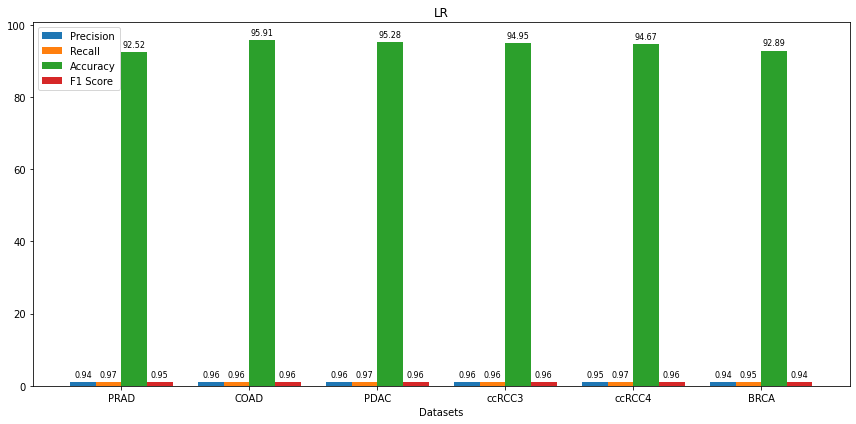

In [215]:
draw_scores_plot_without_eval(precision_scores_lr, recall_scores_lr, accuracy_scores_lr, f1_scores_lr, 'LR')


In [202]:
np.mean(train_accs_autoencoder_cnn)

62.35177782453187

In [115]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def evaluate_model(model, data, labels):
    model.eval()
    with torch.no_grad():
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        precision = precision_score(labels.numpy(), predicted.numpy(), average='weighted')
        recall = recall_score(labels.numpy(), predicted.numpy(), average='weighted')
        accuracy = accuracy_score(labels.numpy(), predicted.numpy())
        f1 = f1_score(labels.numpy(), predicted.numpy())
    return precision, recall, accuracy, f1

In [125]:
def draw_scores_plot(models, title):
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    f1_scores = []
    for i, name in enumerate(names):
        model = models[name]

        X_train = pd.DataFrame(missing_value_imputation(datas[i]))
        X_train = normalize_data(X_train)
        X_train = (pd.DataFrame(feature_extraction(X_train).detach().numpy()))
        
        data = torch.tensor(X_train.values, dtype=torch.float32)
        label = torch.tensor(labels[i].values, dtype=torch.long)

        precision, recall, accuracy, f1 = evaluate_model(model, data, label)
        precision_scores.append(precision)
        recall_scores.append(recall)
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    x = np.arange(len(names))
    width = 0.2 

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width - width/2, precision_scores, width, label='Precision')
    rects2 = ax.bar(x - width/2, recall_scores, width, label='Recall')
    rects3 = ax.bar(x + width/2, accuracy_scores, width, label='Accuracy')
    rects4 = ax.bar(x + width + width/2, f1_scores, width, label='F1 Score')

    ax.set_xlabel('Datasets')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('%.2f' % height,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)

    fig.tight_layout()
    plt.show()



Test Loss: 0.0483
Epoch [10/10], Loss: 0.0518


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.0583
Epoch [10/10], Loss: 0.0578


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.0729
Epoch [10/10], Loss: 0.0665
Test Loss: 0.1054
Epoch [10/10], Loss: 0.1052


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1316
Epoch [10/10], Loss: 0.1285
Test Loss: 0.0547
Epoch [10/10], Loss: 0.0543


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


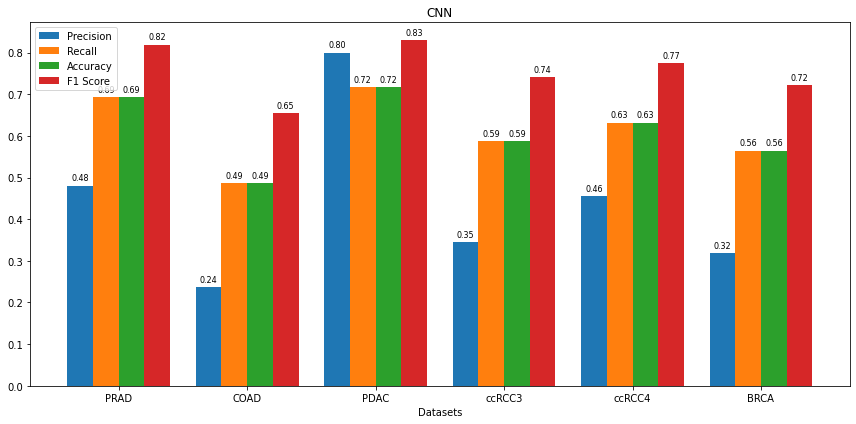

In [137]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

precision_scores = []
recall_scores = []
accuracy_scores = []
f1_scores = []

def evaluate_model(model, data, labels):
    model.eval()
    with torch.no_grad():
        outputs = model.forward(data)
        _, predicted = torch.max(outputs, 1)
        precision = precision_score(labels.numpy(), predicted.numpy(), average='weighted')
        recall = recall_score(labels.numpy(), predicted.numpy(), average='weighted')
        accuracy = accuracy_score(labels.numpy(), predicted.numpy())
        f1 = f1_score(labels.numpy(), predicted.numpy())

    return precision, recall, accuracy, f1

for i, name in enumerate(names):
    model = models_cnn[name]
    X_train = pd.DataFrame(missing_value_imputation(datas[i]))
    X_train = normalize_data(X_train)
    X_train = (pd.DataFrame(feature_extraction(X_train).detach().numpy()))
    
    data = torch.tensor(X_train.values.reshape(int(len(X_train)), 1, X_train.shape[1]), dtype=torch.float32)
    label = torch.tensor(labels[i].values, dtype=torch.long)
    precision, recall, accuracy, f1 = evaluate_model(model, data, label)
    precision_scores.append(precision)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

x = np.arange(len(names))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width - width/2, precision_scores, width, label='Precision')
rects2 = ax.bar(x - width/2, recall_scores, width, label='Recall')
rects3 = ax.bar(x + width/2, accuracy_scores, width, label='Accuracy')
rects4 = ax.bar(x + width + width/2, f1_scores, width, label='F1 Score')

ax.set_xlabel('Datasets')
ax.set_title('CNN')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.show()

Test Loss: 0.0483
Epoch [10/10], Loss: 0.0518
Test Loss: 0.0584
Epoch [10/10], Loss: 0.0579


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.0728
Epoch [10/10], Loss: 0.0665
Test Loss: 0.1054
Epoch [10/10], Loss: 0.1052
Test Loss: 0.1315
Epoch [10/10], Loss: 0.1284
Test Loss: 0.0548
Epoch [10/10], Loss: 0.0543


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


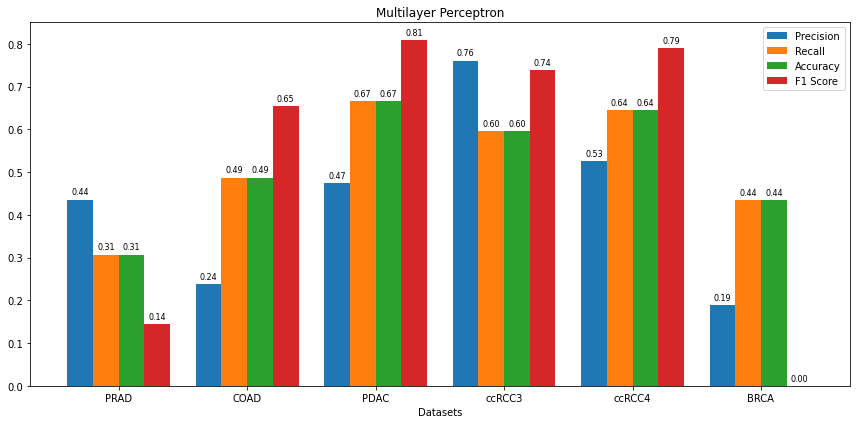

In [126]:
draw_scores_plot(models=models_mlp, title='Multilayer Perceptron')

Test Loss: 0.0482
Epoch [10/10], Loss: 0.0517


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.0582
Epoch [10/10], Loss: 0.0577


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.0728
Epoch [10/10], Loss: 0.0664


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1052
Epoch [10/10], Loss: 0.1051
Test Loss: 0.1316
Epoch [10/10], Loss: 0.1285


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.0548
Epoch [10/10], Loss: 0.0543


/Users/utku/anaconda3/envs/metaboliticsenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


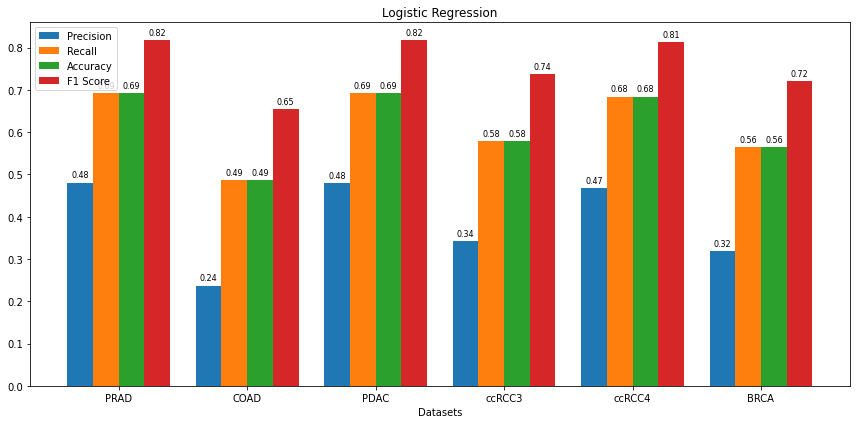

In [127]:
draw_scores_plot(models=models_logistic_regression, title='Logistic Regression')